# HOPP Example 03: Hybrid Plant with Battery Dispatch for a Constan Power Load
Looks at a 50 MW plant (interconnection), with 50 MW of installed wind and 50 MW of installed solar and a 20 MW battery.  The plant site is located at the NREL Flatirons.  In this case, the load-following battery dispatch is used, which follows the given loading while minimizing operating costs of the plant.



In [1]:
import sys
import os
from pathlib import Path
import json
from pathlib import Path
import pandas as pd
import numpy as np
sys.path.append('')

from hybrid.sites import SiteInfo, flatirons_site
from hybrid.hybrid_simulation import HybridSimulation
from hybrid.log import hybrid_logger as logger
from hybrid.keys import set_nrel_key_dot_env
from hybrid.dispatch.plot_tools import plot_battery_output, plot_battery_dispatch_error, plot_generation_profile


examples_dir = Path("examples")

# Set API key
set_nrel_key_dot_env()

/mnt/c/Users/gstarke/Documents/Research_Programs/HOPP/HOPP/log/hybrid_systems_2023-01-19T16.37.40.241688.log


## Setting the plant characteristics

In [2]:
# Set characteristics of the system - NREL Flatirons site 

# Set wind, solar, and interconnection capacities (in MW)
solar_size_mw = 50
wind_size_mw = 50
battery_capacity_mw = 20
interconnection_size_mw = 50

technologies = {
    'pv': {
        'system_capacity_kw': solar_size_mw * 1000,
    },
    'wind': {
        'num_turbines': 25,
        'turbine_rating_kw': int(wind_size_mw * 1000 / 25)
    },
    'battery': {
        'system_capacity_kwh': battery_capacity_mw * 4 *1000,
        'system_capacity_kw': battery_capacity_mw * 1000
    }
}

baseload_limit_kw = float(20 * 1000)
baseload_percent = 95.0
desired_load = baseload_limit_kw*np.ones((8760))/1000
dispatch_options = {'battery_dispatch': 'simple', 'grid_charging': False, 'use_baseload' :True,\
        'baseload':{'limit':baseload_limit_kw, 'compliance_factor': baseload_percent}}

## Loading the resource and site data

In [4]:
# Load the resource information
lat = flatirons_site['lat']
lon = flatirons_site['lon']
prices_file = examples_dir.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv"
site = SiteInfo(flatirons_site, grid_resource_file=prices_file, desired_schedule=desired_load)

## Running the hybrid plant
Note: this cell will take some time to run (a few minutes), since it's running optimized battery dispatch over the whole year

In [5]:
# Create model
hybrid_plant = HybridSimulation(technologies, site, interconnect_kw=interconnection_size_mw * 1000,\
                        dispatch_options=dispatch_options)

# Adjust some inptus to the model 
hybrid_plant.pv.dc_degradation = (0,)             # year over year degradation
hybrid_plant.wind.wake_model = 3                # constant wake loss, layout-independent
hybrid_plant.wind.value("wake_int_loss", 3)     # percent wake loss

hybrid_plant.pv.system_capacity_kw = solar_size_mw * 1000
hybrid_plant.wind.system_capacity_by_num_turbines(wind_size_mw * 1000)

# prices_file are unitless dispatch factors, so add $/kwh here
hybrid_plant.ppa_price = 0.04

# use single year for now, multiple years with battery not implemented yet
plant_life = 25
hybrid_plant.simulate(project_life=plant_life)


dispatch options:  {'battery_dispatch': 'simple', 'grid_charging': False, 'use_baseload': True, 'baseload': {'limit': 20000.0, 'compliance_factor': 95.0}}
Simulating system with dispatch optimization...
	 0 % complete
	 20 % complete
	 40 % complete
	 60 % complete
	 80 % complete
Percent of time firm power requirement is met:  85.31
Percent total firm power requirement is satisfied:  90.55


## Writing the outputs from the simulation

output after losses over gross output 0.8094133202751749
{"pv": 104053614.17242989, "wind": 164459901.74508896, "battery": -308405.81446845416, "hybrid": 158638267.4846797}
{"pv": -4631786.855540685, "wind": -9081152.711365469, "battery": -28123887.96638812, "hybrid": -82013395.16669089}


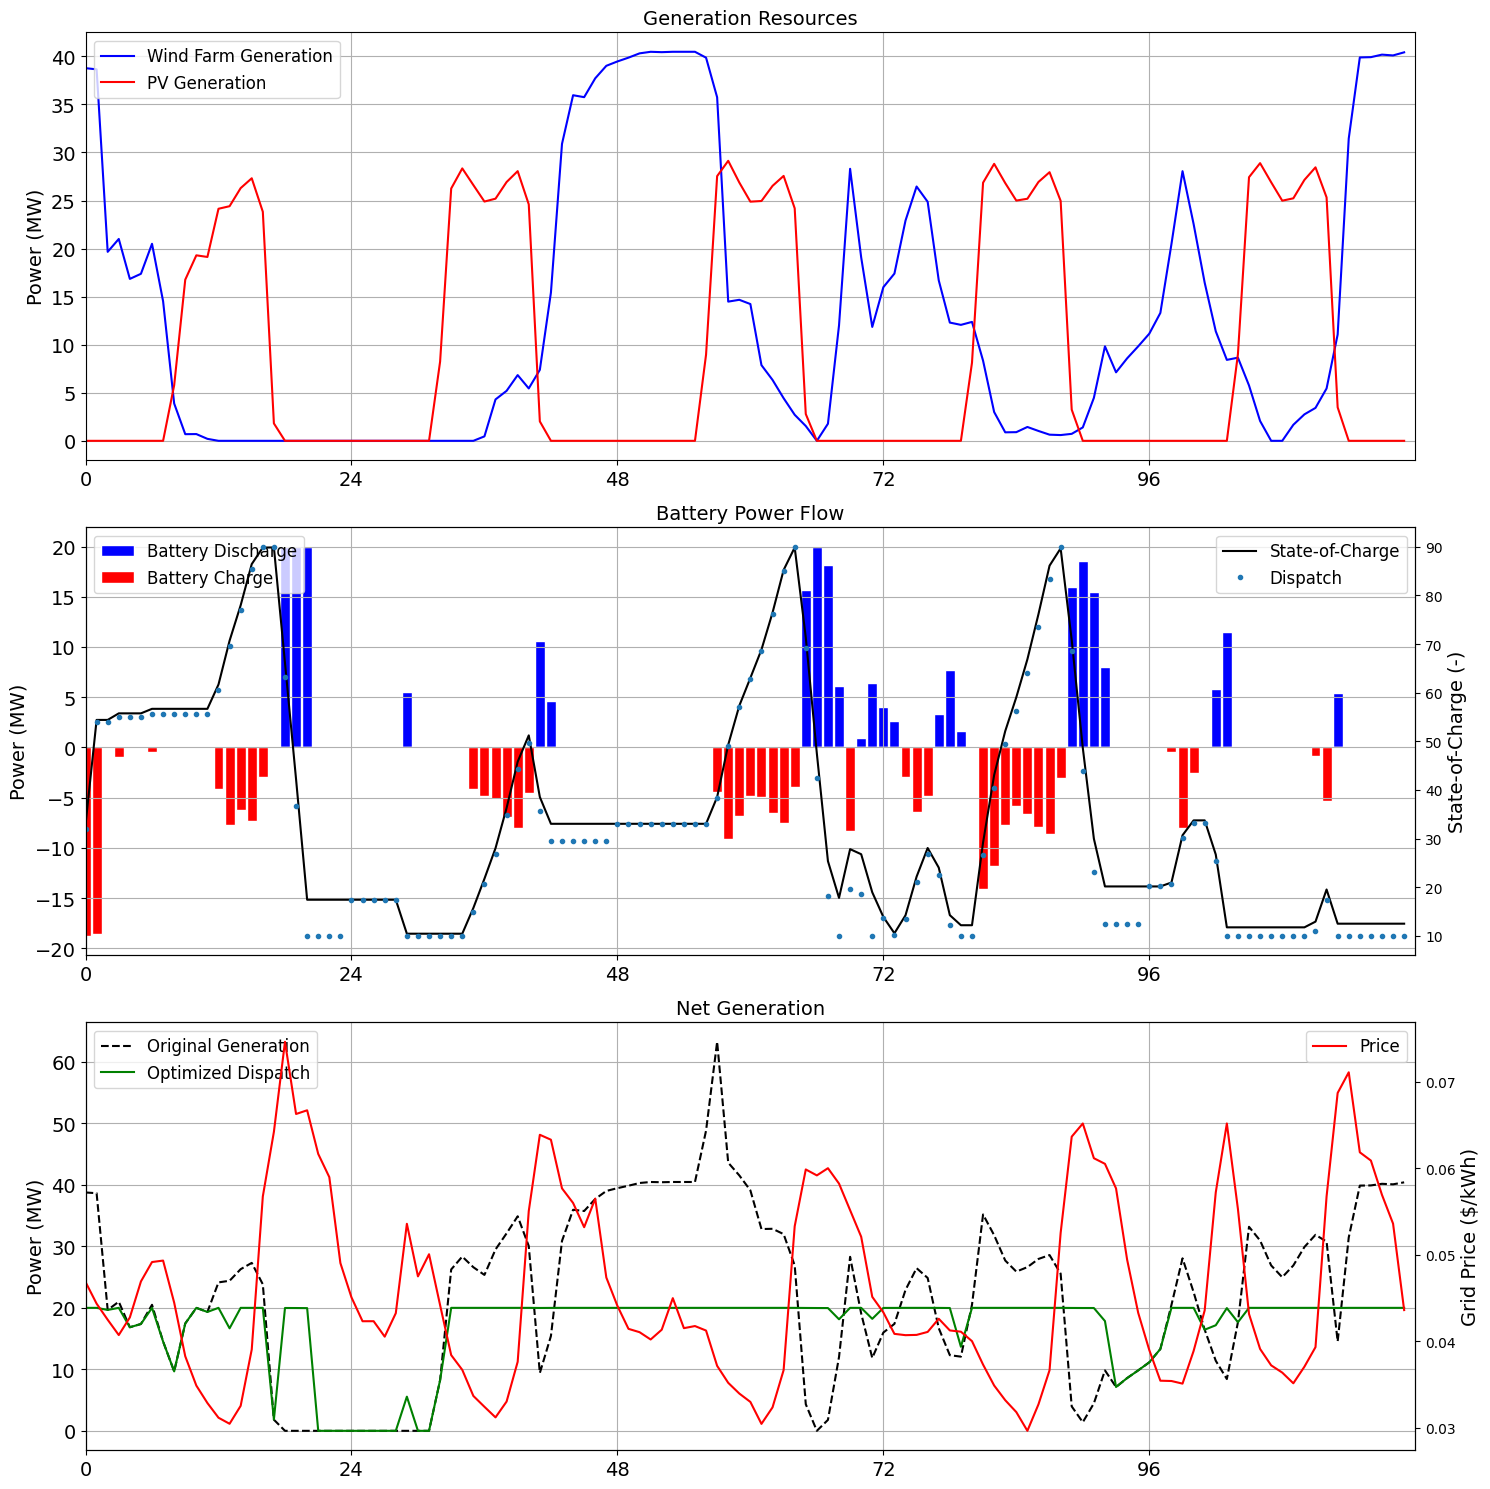

In [6]:

print("output after losses over gross output",
      hybrid_plant.wind.value("annual_energy") / hybrid_plant.wind.value("annual_gross_energy"))

# Save the outputs
annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values
revs = hybrid_plant.total_revenues
print(annual_energies)
print(npvs)
# print(revs)


file = 'figures/'
tag = 'simple2_'
#plot_battery_dispatch_error(hybrid_plant, plot_filename=file+tag+'battery_dispatch_error.png')
'''
for d in range(0, 360, 5):
    plot_battery_output(hybrid_plant, start_day=d, plot_filename=file+tag+'day'+str(d)+'_battery_gen.png')
    plot_generation_profile(hybrid_plant, start_day=d, plot_filename=file+tag+'day'+str(d)+'_system_gen.png')
'''
# plot_battery_dispatch_error(hybrid_plant)
# plot_battery_output(hybrid_plant)
plot_generation_profile(hybrid_plant)
#plot_battery_dispatch_error(hybrid_plant, plot_filename=tag+'battery_dispatch_error.png')
